# Assignment 6: Image Classification with a CNN [ __ / 70 marks + Bonus]

<hr>
<img src="https://miro.medium.com/max/601/1*MBSM_G12XN105sEHsJ6C3A.png" width=500px>
<hr>

In this assignment we will alter a provided CNN (Convolutional Neural Network); we will call the original CNN the `control model` and the modified CNN the `experimental model`. After training and validating the models, we will evaluate them. We will consider a single dataset (images of cats and dogs).

<hr style="height:3px;border:none;color:#333;background-color:#333;" />

### <font color='blue'>What's the task?</font> 
* Make a **specific change** (or set of changes) to the provided CNN while keeping all other aspects fixed. For example, you could `change the model architecture` by adding or removing particular convolutional/max pooling layers. As another example, you could consider `using a different activation function`. As mentioned above, we'll refer to the provided CNN as the **control model** and altered CNN as the **experimental model**.

<hr style="height:3px;border:none;color:#333;background-color:#333;" />

### What's the point?
* In my experience, I have seen many published machine learning/ deep learning papers where a small, but important change (resulting in some improvement) is the basis for that paper. 
* So, I think a good skill to develop in this field is being able to compare models, while fixing other variables. This kind of "experimenting" will serve as a good jumping off point, I think.
* Finally, for those looking to go into industry, I think having some baseline experience with training a CNN will be helpful. Again, as a starting point, with which you can eventually do more advanced projects and build your portfolio. 


### Alternatives?
* If you want to `go further` with the assignment, you'll get up to a max of 10 bonus marks (but more importantly, the goal is that you'll have more interest). By "further", I'm being vague as I want to leave it open-ended for you. You can, for example, do any of the following:
    * Compare one Reinforcement Learning architecture to one which has had some aspect modified.
    * Consider another task (image segmentation) --- as with the RL option, you'd need another dataset
    * Go further into the model comparison (i.e. make other comparative models and perform further analysis).
    * Many other options --> for those who don't have a project in the course, you can think of this as an optional "mini-project" for credit.

### Provided code:
* All the code for loading the dataset, creating and training/validating the control CNN, and getting the model outputs are provided.

### Dependencies:
* You will need to install the `pytorch` and `torchvision` packages. You can do this in a terminal by going to File -> New -> Terminal from the JupyterLab menu, and running `conda install torchvision -c pytorch`

### <font color='red'>One warning</font>:
* Depending on your computer's hardware, you may need to scale back your experiments. You can try reducing the number of training iterations, the size of your training set, or the size of your model architecture. Just focus on creating a controlled experiment. 
* Along these lines, don't run experiments that will take too long to run. Test your experiments on a small number of training iterations (5 or so) to get a sense of how long each iteration takes. Then, you run your final experiments with more training iterations when ready.


In [3]:
# all imports for the assignment here

%matplotlib inline
%run Live_plot.py

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import PIL

from IPython.display import display
from matplotlib.image import imread
from matplotlib import rcParams, rcParamsDefault
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Provided code for data loading

In [71]:
# define tranforms
norm_mean = [0.494, 0.486, 0.447] # mean values of r,g,b in the images (specific to this dataset)
norm_std = [0.246, 0.242, 0.263] # standard deviation of r,g,b in the images (specific to this dataset)

# transform the data
transform = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [72]:
# create train/valid sets
dataset_train = datasets.ImageFolder('./cats_and_dogs_small/train', transform)
dataset_validation = datasets.ImageFolder('./cats_and_dogs_small/validation', transform)
  
# load sets for train/valid
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset_validation, batch_size=32)

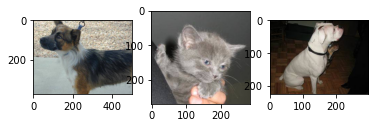

Before we transform the images...
Size of first image: (499, 375)
Size of second image: (286, 270)
Size of third image: (299, 225)
************************************************************


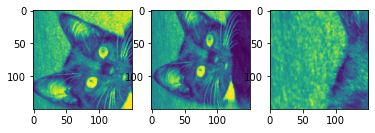

After we transform the images...
Size of each image: torch.Size([150, 150])


In [73]:
# show some sample images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
image1 = imread('./cats_and_dogs_small/train/dogs/dog.3.jpg')
image2 = imread('./cats_and_dogs_small/train/cats/cat.28.jpg')
image3 = imread('./cats_and_dogs_small/train/dogs/dog.19.jpg')
ax1.imshow(image1)
ax2.imshow(image2)
ax3.imshow(image3); plt.show()

print("Before we transform the images...")
print(f"Size of first image: {PIL.Image.open('./cats_and_dogs_small/train/dogs/dog.3.jpg').size}")
print(f"Size of second image: {PIL.Image.open('./cats_and_dogs_small/train/cats/cat.28.jpg').size}")
print(f"Size of third image: {PIL.Image.open('./cats_and_dogs_small/train/dogs/dog.19.jpg').size}")

print("*"*60)


tr_image_ex1_1 = dataset_train[5][0][0]
tr_image_ex1_2 = dataset_train[5][0][1]
tr_image_ex1_3 = dataset_train[5][0][2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(torch.t(tr_image_ex1_1))
ax2.imshow(torch.t(tr_image_ex1_2))
ax3.imshow(torch.t(tr_image_ex1_3)); plt.show()

print("After we transform the images...")
print(f"Size of each image: {dataset_train[5][0][0].shape}")

## Provided code for model architecture

In [93]:
# define the control CNN class
class CNN(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.2) -> None:
        super().__init__()
        # "self.features" specifies convolutions/pooling/normalization/activation, in order (with nn.Sequential)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=3, padding=2),
            
            # "BatchNorm2d" (Batch Normalization) normalizes a layer: reduces weight imbalances, speeds up training
            nn.BatchNorm2d(num_features=32), # num_features corresponds to 32 channels; outputs same size as input
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        #"self.classifier" specifies the Multilayer Perceptron layers/activation/dropout, in order (nn.Sequential)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * 5 * 5, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=num_classes),
        )

    # The "forward" method starts from input image x, applies the entire model (in order), and outputs the class
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x

## Provided code to train/validate model

In [2]:
# here we train and validate our model for max_iter "epochs", with batch_limit images (x2) used for each epoch
batch_limit = 100 # for each epoch, we consider 100 images
num_classes = 2 # the classes are "cat" and "dog" (2 classes)
num_epochs = 30 #this is the number of epochs we train/validate

# side note on the validation: it may seem a bit strange, but here we train on batch_limit training samples AND do 
# predictions on batch_limit validation samples. So, the model adjusts its weights from the training set, and 
# performs predictions on the validation set. We will store and plot the overall loss/accuracy after each epoch.

model = CNN(num_classes) # create an instance (object) of our CNN class
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # use Adam, learning rate 0.001
criterion = torch.nn.CrossEntropyLoss() # our loss function (we use Cross Entropy loss)
# Note about torch.nn.CrossEntropyLoss() --> this combines a Softmax activation + a cross entropy loss function

# these lists (tr_loss, tr_acc, val_acc) store the training losses, training accuracies, and validation accuracies.
tr_loss = []
tr_acc = []
val_acc = []

# for the last validation set, these lists (yval, ypr) store the labeled class outputs (yval) and predictions (ypr)
yval = []
ypr = []

# for num_epochs iterations, train and validate the CNN
for i in range(num_epochs):
    epoch_loss = 0 #initialize loss to 0
    print(f"Currently on epoch {i}...")
    
    count = 0
    
    # TRAIN--------------------------------------------------------------------------------------
    model.train() #sets the model into "training mode" 
    
    # for a batch of training data, apply CNN, get loss, and do backpropagation to adjust parameters
    for index, (data, label) in enumerate(train_loader):
        optimizer.zero_grad() #reset optimizer
        y_pred = model(data) # apply CNN on input data
        y_pred_class = y_pred.argmax(dim=1) 
        count += y_pred_class.eq(label.view_as(y_pred_class)).sum().item() #compute correct guesses
        loss = criterion(input=y_pred, target=label) # get loss of predictions
        loss.backward() # apply backprop through CNN
        optimizer.step() # updates all the weights/parameters
        epoch_loss += loss.item() # update loss in this epoch

        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break

    t_acc = count/len(dataset_train) #get training accuracy --> correct guesses/total predictions
    tr_acc.append(t_acc*100) # add training accuracy to the training accuracy list


    # VALIDATE--------------------------------------------------------------------------------------
    model.eval() #sets the model into "evaluation mode"
    correct = 0
    
    #save the validation predictions and labels (for creating the confusion matrix)
    if(i==num_epochs-1):
        with torch.no_grad(): # no backprop for validation
            tr_loss.append(epoch_loss/batch_limit) # store the training loss (not a validation step)
            # for a batch of validation data, apply CNN, get the predictions (no backprop, no param changes)
            for index, (data, label) in enumerate(validation_loader):
                pred = model(data)
                pred_class = pred.argmax(dim=1)
                ypr.append(pred_class)
                yval.append(label.view_as(pred_class))
                correct += pred_class.eq(label.view_as(pred_class)).sum().item()
                
    if(i!=num_epochs-1):
        with torch.no_grad(): # no backprop for validation
            tr_loss.append(epoch_loss/batch_limit)
            for index, (data, label) in enumerate(validation_loader):
                pred = model(data)
                pred_class = pred.argmax(dim=1)         
                correct += pred_class.eq(label.view_as(pred_class)).sum().item()
    
    v_acc = correct/len(dataset_validation) #calculate the validation accuracy
    val_acc.append(v_acc*100) # add the validation accuracy to the list, val_acc
    
    live_plot(np.array(tr_loss), np.array(tr_acc), val_acc) # plot the train loss, train/valid accuracy

PATH = './ctrl_model.pth'
torch.save(model.state_dict(), PATH)

## Some extra code/data/info for your use

In [2]:
# first, I have saved the weights from when I trained the control model CNN
# if you want to quickly use those weights, you can use the following code (uncomment below):

#PATH = './ctrl_model.pth'
#model.load_state_dict(torch.load(PATH)) # note: I named my CNN "model"



# second, here are the validation labels and predictions from my CNN model (uncomment below):
#with open('yval_ctrl.npy', 'rb') as f:
#    yval_control_model = np.load(f)

#with open('ypr_ctrl.npy', 'rb') as f:    
#    ypred_control_model = np.load(f)



# third, here is some code to get the final ypr, yval values for your model (uncomment below)
#yval_final = np.concatenate([i.detach().numpy() for i in yval])
#ypr_final = np.concatenate([i.detach().numpy() for i in ypr])



# finally, below is a plot of the train/validation results for my run of the control CNN

<img align="left" src="plot_ctrl.png" width=500px>

## Ok, here are the actual questions...

## Part 1: Define Control, Experimental Models [ _ /35 marks]

Your task: Make **one or more significant changes** to the provided CNN. The original CNN will be your `control` model, and your modified model will be your `experimental` model. Make sure that you are not changing any of the other aspects for the comparison (i.e. if you change the CNN depth, don't use less training data for one model over another). Note: some of the marking for parts 1&2 will be holistic in nature (i.e. assessing overall answer quality).

### Question 1.1 [ _ /10 marks]
**Describe the control model**. Consider some (i.e. 5) of these aspects: How many layers are there? What are the filter sizes? What is the input image size? What is the activation function? Is a different activation applied in the final layer? What is the loss function? How many output classes are there?

**Your answer**:
1. How many layers are there? There are 4 conv layers, 3 max pooling layers, 4 batch normalization layers and 3 fully connected layer in the classifier. So there are 14 layers in total.
2. What are the filter sizes? The filter size is 3 x 3
3. What is the input image size? The input image size is 150 x 150
4. What is the activation function? Relu
5. Is a different activation applied in the final layer? No, the activation applied in the final layer is also Relu
6. What is the loss function? The loss functoin is Cross Entropy loss.
7. How many output classes are there? 2

### Question 1.2 [ _ /10 marks]
**Describe the experimental model**. Specifically, describe the particular aspect of the control model which you are changing to create your experimental model. Next, **describe what you predict will happen** (i.e. to your training loss, classification accuracy, etc.) as a result of this change. 

**Your answer**: 

### Question 1.3 [ _ /15 marks]

**Define your model here**. You can copy and paste the provided CNN code *for the control model* and apply your changes to *create the experimental model*. 

In [3]:
# define the control CNN class
class CNN(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.2) -> None:
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)

        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * 5 * 5, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=num_classes),
        )

    # The "forward" method starts from input image x, applies the entire model (in order), and outputs the class
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x

## Part 2: Model Evaluation and Comparison [ _ /35 marks]

### Question 2.1 [ _ /10 marks]

Train and validate your experimental model (you can copy-paste and adapt the code provided for the control model). Next, plot the training loss, training accuracy, and validation accuracy over all epochs. Save your final model weights; for this you can use torch.save() with `PATH = './exp_model.pth')`.

In [ ]:
# here we train and validate our model for max_iter "epochs", with batch_limit images (x2) used for each epoch
batch_limit = 100 # for each epoch, we consider 100 images
num_classes = 2 # the classes are "cat" and "dog" (2 classes)
num_epochs = 30 #this is the number of epochs we train/validate

# side note on the validation: it may seem a bit strange, but here we train on batch_limit training samples AND do 
# predictions on batch_limit validation samples. So, the model adjusts its weights from the training set, and 
# performs predictions on the validation set. We will store and plot the overall loss/accuracy after each epoch.

model = CNN(num_classes) # create an instance (object) of our CNN class
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # use Adam, learning rate 0.001
criterion = torch.nn.CrossEntropyLoss() # our loss function (we use Cross Entropy loss)
# Note about torch.nn.CrossEntropyLoss() --> this combines a Softmax activation + a cross entropy loss function

# these lists (tr_loss, tr_acc, val_acc) store the training losses, training accuracies, and validation accuracies.
tr_loss = []
tr_acc = []
val_acc = []

# for the last validation set, these lists (yval, ypr) store the labeled class outputs (yval) and predictions (ypr)
yval = []
ypr = []

# for num_epochs iterations, train and validate the CNN
for i in range(num_epochs):
    epoch_loss = 0 #initialize loss to 0
    print(f"Currently on epoch {i}...")
    
    count = 0
    
    # TRAIN--------------------------------------------------------------------------------------
    model.train() #sets the model into "training mode" 
    
    # for a batch of training data, apply CNN, get loss, and do backpropagation to adjust parameters
    for index, (data, label) in enumerate(train_loader):
        optimizer.zero_grad() #reset optimizer
        y_pred = model(data) # apply CNN on input data
        y_pred_class = y_pred.argmax(dim=1) 
        count += y_pred_class.eq(label.view_as(y_pred_class)).sum().item() #compute correct guesses
        loss = criterion(input=y_pred, target=label) # get loss of predictions
        loss.backward() # apply backprop through CNN
        optimizer.step() # updates all the weights/parameters
        epoch_loss += loss.item() # update loss in this epoch

        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break

    t_acc = count/len(dataset_train) #get training accuracy --> correct guesses/total predictions
    tr_acc.append(t_acc*100) # add training accuracy to the training accuracy list


    # VALIDATE--------------------------------------------------------------------------------------
    model.eval() #sets the model into "evaluation mode"
    correct = 0
    
    #save the validation predictions and labels (for creating the confusion matrix)
    if(i==num_epochs-1):
        with torch.no_grad(): # no backprop for validation
            tr_loss.append(epoch_loss/batch_limit) # store the training loss (not a validation step)
            # for a batch of validation data, apply CNN, get the predictions (no backprop, no param changes)
            for index, (data, label) in enumerate(validation_loader):
                pred = model(data)
                pred_class = pred.argmax(dim=1)
                ypr.append(pred_class)
                yval.append(label.view_as(pred_class))
                correct += pred_class.eq(label.view_as(pred_class)).sum().item()
    if(i!=num_epochs-1):
        with torch.no_grad(): # no backprop for validation
            tr_loss.append(epoch_loss/batch_limit)
            for index, (data, label) in enumerate(validation_loader):
                pred = model(data)
                pred_class = pred.argmax(dim=1)         
                correct += pred_class.eq(label.view_as(pred_class)).sum().item()
    
    v_acc = correct/len(dataset_validation) #calculate the validation accuracy
    val_acc.append(v_acc*100) # add the validation accuracy to the list, val_acc
    
    live_plot(np.array(tr_loss), np.array(tr_acc), val_acc) # plot the train loss, train/valid accuracy

PATH = './exp_model.pth'
torch.save(model.state_dict(), PATH)

### Question 2.2 [ _ /10 marks]

Compare the validation results of the control and experimental models. Create a `confusion matrix` for each. Which model performed better on the validation set?  See the section above (`"Some extra code/data/info for your use"`) for any control model outputs/data that you need.

In [ ]:
# --------- your code below !!!!









### Question 2.3 [ _ /15 marks]

Finally, write a small paragraph which addresses the following:
* Discuss your change to the control model (used to make the experimental model). What did you predict would happen from this change? What actually happened? 
* Let's assume that I told you that `it took me 45 minutes to train the control model` on my computer. Could you use my result in comparison to yours? Why or why not?
* Given your results, if you were to create a second experimental model, what is another possible change you would be interested in making for comparison?

**Your answer**:

## Before you submit..
* Make sure that your submission includes `this filled notebook` in addition to your `final experimental CNN weights`.